### Load and Prepare the Dataset

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:

tf.random.set_seed(42)
np.random.seed(42)

In [4]:
df = pd.read_csv('IMDB Dataset.csv')

# Convert sentiment labels to binary (0 for negative, 1 for positive)
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# Display dataset info
print(f"Dataset size: {len(df)}")
print(df.head())

Dataset size: 50000
                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


###  Preprocess the Text Data

In [5]:
# Parameters
VOCAB_SIZE = 10000  # Number of most frequent words to keep
MAX_LEN = 200       # Maximum length of sequences
EMBEDDING_DIM = 32  # Dimension of word embeddings

In [6]:

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:

# Initialize tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['review'])

In [8]:

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['review'])
test_sequences = tokenizer.texts_to_sequences(test_df['review'])

In [9]:

# Pad sequences to make them uniform length
X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [10]:

# Get labels
y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (40000, 200)
Test data shape: (10000, 200)


### Build the GRU Model

In [11]:
model = Sequential([
    # Embedding layer converts word indices to dense vectors
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    
    # GRU layer with 64 units
    # The GRU processes the sequence and captures temporal dependencies
    GRU(64, return_sequences=False),  # We only want the final output, not the sequence
    
    # Dense output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

model.summary()

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compile and Train the Model

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 94ms/step - accuracy: 0.9731 - loss: 0.0879 - val_accuracy: 0.8677 - val_loss: 0.4201
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.9766 - loss: 0.0746 - val_accuracy: 0.8679 - val_loss: 0.4716
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.9812 - loss: 0.0618 - val_accuracy: 0.8651 - val_loss: 0.5167
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.9851 - loss: 0.0531 - val_accuracy: 0.8607 - val_loss: 0.5329
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.9880 - loss: 0.0440 - val_accuracy: 0.8599 - val_loss: 0.5468


### Evaluate and Make Predictions

In [18]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8668 - loss: 0.5289

Test Accuracy: 0.8599


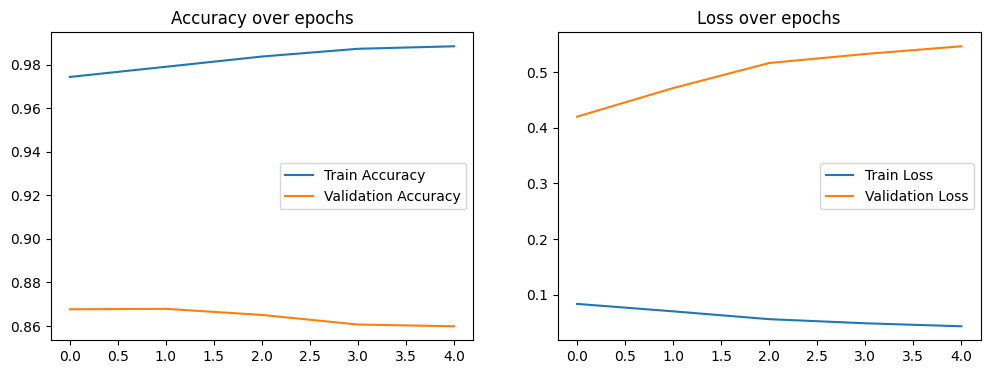

In [19]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [20]:

# Make predictions on some test samples
sample_texts = test_df['review'].head(3).tolist()
sample_labels = test_df['sentiment'].head(3).tolist()

# Preprocess the sample texts
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Predict
predictions = model.predict(sample_padded).flatten()
predicted_labels = [1 if p > 0.5 else 0 for p in predictions]

# Display results
for text, true_label, pred_label, prob in zip(sample_texts, sample_labels, predicted_labels, predictions):
    print(f"\nReview: {text[:200]}...")
    print(f"True Sentiment: {'Positive' if true_label else 'Negative'}")
    print(f"Predicted Sentiment: {'Positive' if pred_label else 'Negative'} (confidence: {prob:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step

Review: I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ev...
True Sentiment: Positive
Predicted Sentiment: Positive (confidence: 0.9988)

Review: Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you ca...
True Sentiment: Positive
Predicted Sentiment: Positive (confidence: 0.9997)

Review: The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy hijacking Steven Seagal would have been beaten to pulp by Seagal's driving, but tha...
True Sentiment: Negative
Predicted Sentiment: Negative (confidence: 0.0004)
